# XGBoost aplicado ao problema de churn 

churn: métrica da quantidade pessoas que deixam ou não uma organização, ou que deixam ou não de utilizar um serviço.
<br>

## Organização do projeto

- Importação dos dados

- Tratamento dos dados faltantes

    - Identificação dos dados faltantes

    - Lidando com os dados faltantes
    
- Formatação dos dados para aplicação do modelo XGBoost

    - Separando os dados em variáveis dependentes e variáveis independentes
    - One-Hot-Encoding
    - Conversão de todas as colunas para Int, Float, ou Bool
<br>
<br>
- Contrução de um modelo XGBoost preliminar

- Otmização dos parâmetros com Cross Validation e GridSearch

    - Otimizando o learning rate, tree depth, number of tree, gamma (for prunning) e lambda (for regularization)
<br>
<br>

- Construindo, desenhando, interpretando e avaliando o modelo XGBoost otimizado


1. Criação de um ambiente virtual para isolar as dependências desse projeto e atualização do pip
````prompt
>>> python -m venv env
>>> python -m pip install --upgrade pip
````

2. Verificação das configurações do ambiente de desenvolvimento
Ambiente de desenvolvimento: VSCode <br>
python 3.9.6 64-bit

````prompt
>>> python --version
3.9.6
>>> jupyter --version
jupyter core     : 4.7.1
jupyter-notebook : 6.4.7
qtconsole        : 5.2.2
ipython          : 7.26.0
ipykernel        : 6.2.0
jupyter client   : 7.0.1
jupyter lab      : 3.2.8
nbconvert        : 6.4.0
ipywidgets       : 7.6.5
nbformat         : 5.1.3
traitlets        : 5.0.5
````


3. Salve as libs utilizadas em um arquivo requirements.txt

````prompt
pip freeze > requirements.txt
````

### Importando os modulos

In [1]:
# Versão do python: 3.9.6
import pandas as pd # para carregamento e manipulação dos dados, assim como aplicação do método One-Hot Encoding
import numpy as np # para cálculo da média e desvio padrão
import xgboost as xgb # para acesso à lib xgboost
from sklearn.model_selection import train_test_split # para dividir a amostra em um grupo para treino e outro para teste
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # para obter métricas de desempenho do modelo
from sklearn.model_selection import GridSearchCV # para otimização de parâmetros com validação cruzada
from sklearn.metrics import confusion_matrix # para criação de uma matrix de confusão
from sklearn.metrics import plot_confusion_matrix

from descarta_colunas import descarta_colunas_com_um_unico_valor # descarta as colunas que possuem um único valor
from summary import * # Importação de todo o conteúdo do arquivo sumary.py para realizar a descrição dos dados

d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Importando os dados

Foi utilizada a base de dados do [IBM Base Samples](https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=samples-base) (acesso em 10/04/2022). Foi utilizada especificamente [Telco Churn Dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) (acesso em 10/04/2022). O download dos dados ["Telco Customer Churn"](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) foi feito a partir do Kaggle.

Esses dados vão nos permitir prever se alguém vai parar ou não de usar os serviços da Telco a partir de várias tipos de dados tanto categóricos como contínuos.


In [2]:
df = pd.read_csv("Telco_customer_churn.csv")

In [3]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
features = list(df.columns)
features


['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [5]:
features_sorted = sorted(features)
print(features_sorted, "/t")

['Churn', 'Contract', 'Dependents', 'DeviceProtection', 'InternetService', 'MonthlyCharges', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner', 'PaymentMethod', 'PhoneService', 'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TotalCharges', 'customerID', 'gender', 'tenure'] /t


Vamos remover colunas que não tem significado para o modelo como:
customerID

In [6]:
df.drop(["customerID"],
        axis=1, # escolha axis = 0 para remover linhas, axis = 1 para remover colunas (features)
        inplace=True # para substituir o resultado do drop no próprio dataframe df
)

Examinando os dados com describe, info e através de uma função summary

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [9]:
summary(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
max,Male,1,Yes,Yes,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,118.75,999.9,Yes
min,Female,0,No,No,0,No,No,DSL,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),18.25,,No
categorias_unicas,2,2,2,2,73,2,3,3,3,3,3,3,3,3,3,2,4,1585.00,6531,2


In [10]:
df = descarta_colunas_com_um_unico_valor(df)

0:  gender 
Valores únicos: 2
______________________________________________________________________________________________________________________________________________________
1:  SeniorCitizen 
Valores únicos: 2
______________________________________________________________________________________________________________________________________________________
2:  Partner 
Valores únicos: 2
______________________________________________________________________________________________________________________________________________________
3:  Dependents 
Valores únicos: 2
______________________________________________________________________________________________________________________________________________________
4:  tenure 
Valores únicos: 73
______________________________________________________________________________________________________________________________________________________
5:  PhoneService 
Valores únicos: 2
______________________________________________

In [11]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
summary(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
max,Male,1,Yes,Yes,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Mailed check,118.75,999.9,Yes
min,Female,0,No,No,0,No,No,DSL,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),18.25,,No
categorias_unicas,2,2,2,2,73,2,3,3,3,3,3,3,3,3,3,2,4,1585.00,6531,2


In [13]:
from tratemento_regex import adiciona_underscore_nos_espacos_dos_nomes_das_colunas
adiciona_underscore_nos_espacos_dos_nomes_das_colunas(df)
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Primeira parte do tratamento está concluída.

- O que foi verificado?
    - Temos colunas com um único valor?
    - Temos colunas que consideramos irrelevantes para o modelo, como "customerID"?
    - Substituímos espaços por por underscore nos dados do tipo string, e também nos nomes das colunas, para que seja possível desenhar a árvore sem problemas. Embora não seja necessário para aplicar o modelo XGBoost.


### Dados faltantes: parte 1

Procuramos por espaçõs em branco, nan etc

XGBoost já consegue lidar com dados faltantes por padrão.

Temos que encontrar os dados faltantes e substituí-los por 0.


- Precisamos verificar se os valores e os tipos de dados das colunas fazem sentido.

In [14]:
def print_type_info(df):
    dict_info = {}
    colunas = []
    Type = []
    unique_valor = []

    for column in df.columns:
        colunas += [column]
        Type += [df[column].dtype]
        unique_valor += [df[column].unique()]
    dict_info.update({"Coluna": colunas, "Type": Type, "unique_valor": unique_valor})
    df_info = pd.DataFrame(dict_info)

    # Default value of display.max_rows is 10 so at max
    # 10 rows will be printed. Set it None to display
    # all rows in the dataframe
    pd.set_option('display.max_rows', None)
    return df_info
print_type_info(df)

,Coluna,Type,unique_valor
0,gender,object,"[Female, Male]"
1,SeniorCitizen,int64,"[0, 1]"
2,Partner,object,"[Yes, No]"
3,Dependents,object,"[No, Yes]"
4,tenure,int64,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ..."
5,PhoneService,object,"[No, Yes]"
6,MultipleLines,object,"[No phone service, No, Yes]"
7,InternetService,object,"[DSL, Fiber optic, No]"
8,OnlineSecurity,object,"[No, Yes, No internet service]"
9,OnlineBackup,object,"[Yes, No, No internet service]"


In [15]:
df["tenure"].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [16]:
df["PaymentMethod"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [17]:
# Checagem de existencia de espaços em branco
for column in df.columns:
    condicao = df[column] == " "
    # para verificar onde a condicao = True no DataFrame 
    df_condicao_true = df.loc[condicao]
    if len(df_condicao_true) > 0:
        print(column, "possui ", len(df_condicao_true), " linhas com espaços em branco.")

TotalCharges possui  11  linhas com espaços em branco.


In [18]:
len(df["tenure"])

7043

A coluna "TotalCharges" que parece ser um monte de números tem o tipo apresentado como object. Por isso precisamos examinar essa coluna com mais atenção.

In [19]:
len(df["MonthlyCharges"])

7043

In [20]:
# Ao tentar a conversão para numérico retorna um erro 
# ValueError: Unable to parse string " " at position 488
# df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

In [21]:
df["TotalCharges"][488]
# Ou seja, temos um espaço vazio na linha 488

' '

In [22]:
condicao = df["TotalCharges"] == " "
# para verificar onde a condicao = True no DataFrame 
df_condicao_true = df.loc[condicao]
df_condicao_true

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [23]:
len(df_condicao_true)

11

Como são apenas 11 casos vamos igualá-los a 0, pois o XGBoost só lida com float, int e bool.

Para isso fazemos

In [24]:
nome_da_coluna = "TotalCharges"
df.loc[condicao, nome_da_coluna] = 0

In [25]:
condicao_zero = df["TotalCharges"] == 0
# para verificar onde a condicao = True no DataFrame 
df_condicao_true_zero = df.loc[condicao_zero]
df_condicao_true_zero

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,No


In [26]:
len(df_condicao_true_zero)

11

In [27]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

In [28]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Temos agora TotalCharges        float64

Agora que lidamos com os dados faltantes podemos substituir todos os espaços de todo o DataFrame por underscore. Isso é somente para imprimir uma árvore bonita. Para o XGBoost utilizamos hotencoding.


In [29]:
df.replace(" ", "_", regex=True, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


### __Formatação dos dados - parte 1:__ Divimos os dados em variáveis dependentes e variáveis independentes.

In [30]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [31]:
X = df.drop("Churn", axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65


In [32]:
y = df["Churn"].copy()
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

### __Formatação dos dados - parte 2:__ One-Hot Encoding

É devido a cada categoria diferente acrescentar uma coluna no DataFrame costuma-se utilizar OneHot Encoding para features com até 10 categorias e descata as demais para um primeiro modelo.


In [33]:
print_type_info(X)

,Coluna,Type,unique_valor
0,gender,object,"[Female, Male]"
1,SeniorCitizen,int64,"[0, 1]"
2,Partner,object,"[Yes, No]"
3,Dependents,object,"[No, Yes]"
4,tenure,int64,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ..."
5,PhoneService,object,"[No, Yes]"
6,MultipleLines,object,"[No_phone_service, No, Yes]"
7,InternetService,object,"[DSL, Fiber_optic, No]"
8,OnlineSecurity,object,"[No, Yes, No_internet_service]"
9,OnlineBackup,object,"[Yes, No, No_internet_service]"


In [34]:
# One-Hot Encoding test
pd.get_dummies(X, columns = ["PaymentMethod"]).head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,...,No,No,Month-to-month,Yes,29.85,29.85,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One_year,No,56.95,1889.50,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,...,No,No,One_year,No,42.30,1840.75,1,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0


In [35]:
list(X.columns)

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [36]:
X["MonthlyCharges"].dtypes == float

True

In [37]:
# Criando uma lista somente com dados do tipo object que serão os utilizados no One-Hot Encoding
one_hot_list = []
for column in X.columns:
    # print(column)
    if X[column].dtypes == object:
        # print(X[column].dtypes)
        one_hot_list.append(column)
one_hot_list

    

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [38]:
print_type_info(X)

,Coluna,Type,unique_valor
0,gender,object,"[Female, Male]"
1,SeniorCitizen,int64,"[0, 1]"
2,Partner,object,"[Yes, No]"
3,Dependents,object,"[No, Yes]"
4,tenure,int64,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ..."
5,PhoneService,object,"[No, Yes]"
6,MultipleLines,object,"[No_phone_service, No, Yes]"
7,InternetService,object,"[DSL, Fiber_optic, No]"
8,OnlineSecurity,object,"[No, Yes, No_internet_service]"
9,OnlineBackup,object,"[Yes, No, No_internet_service]"


In [39]:
one_hot_list

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [40]:
X[one_hot_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            7043 non-null   object
 1   Partner           7043 non-null   object
 2   Dependents        7043 non-null   object
 3   PhoneService      7043 non-null   object
 4   MultipleLines     7043 non-null   object
 5   InternetService   7043 non-null   object
 6   OnlineSecurity    7043 non-null   object
 7   OnlineBackup      7043 non-null   object
 8   DeviceProtection  7043 non-null   object
 9   TechSupport       7043 non-null   object
 10  StreamingTV       7043 non-null   object
 11  StreamingMovies   7043 non-null   object
 12  Contract          7043 non-null   object
 13  PaperlessBilling  7043 non-null   object
 14  PaymentMethod     7043 non-null   object
dtypes: object(15)
memory usage: 825.5+ KB


In [41]:
X_encoded = pd.get_dummies(X, columns = one_hot_list)

In [42]:
X_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,1,29.85,29.85,1,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


# Construindo um __modelo XGBoost prelimilar__

Mas primeiro observemos que os dados para a previsão, variável dependente y (churn), está desbalanceado

In [43]:
y.unique()

array(['No', 'Yes'], dtype=object)

In [44]:
y.replace("No", 0, regex=True, inplace=True)
y.replace("Yes", 1, regex=True, inplace=True)

In [45]:
y.unique()

array([0, 1], dtype=int64)

In [46]:
numero_total_de_amostras = y.count()
numero_total_de_amostras

7043

In [47]:
numero_total_de_de_churn = sum(y)
numero_total_de_de_churn

1869

In [48]:
print("len_X: ", len(X_encoded))
print("len_y: ", len(y))

len_X:  7043
len_y:  7043


In [49]:
percentual_churn = str(round(numero_total_de_de_churn/numero_total_de_amostras, 2)*100) + " %"
print("Churn: ", percentual_churn)

Churn:  27.0 %


Pelo fato de o churn estar desbalanceado vamos utilizar a opção de estratificação do modulo train_test_split, pois assim mantemos a mesma proporção de pessoas que deixaram a companhia (churn) e pessoas que não deixaram, ~27%.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Verificando se os dados estão balanceados

In [51]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.2654297614539947
0.26519023282226006


Ao invés de utilizar um valor ideal de árvores com validação cruzada podemos configurar o parâmetros early_stopping_rounds para parar de construir árvores quando o modelo não melhorar mais.

In [52]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            use_label_encoder=False,
                            missing=1, 
                            seed=42)

In [53]:
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True,
            early_stopping_rounds=20, # para parar de construir árvores quando o modelo não melhorar mais. XGBoost constrói mais 10 árvores e se não houver melhora ele para.
            eval_metric="aucpr",
            eval_set=[(X_test, y_test)]
            )

d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-aucpr:0.63160
[1]	validation_0-aucpr:0.64538
[2]	validation_0-aucpr:0.64402
[3]	validation_0-aucpr:0.64461
[4]	validation_0-aucpr:0.64114
[5]	validation_0-aucpr:0.64016
[6]	validation_0-aucpr:0.64620
[7]	validation_0-aucpr:0.64003
[8]	validation_0-aucpr:0.63913
[9]	validation_0-aucpr:0.64153
[10]	validation_0-aucpr:0.64172
[11]	validation_0-aucpr:0.63950
[12]	validation_0-aucpr:0.63687
[13]	validation_0-aucpr:0.63473
[14]	validation_0-aucpr:0.63442
[15]	validation_0-aucpr:0.63634
[16]	validation_0-aucpr:0.63597
[17]	validation_0-aucpr:0.63454
[18]	validation_0-aucpr:0.63298
[19]	validation_0-aucpr:0.63338
[20]	validation_0-aucpr:0.63146
[21]	validation_0-aucpr:0.62905
[22]	validation_0-aucpr:0.62835
[23]	validation_0-aucpr:0.62847
[24]	validation_0-aucpr:0.62797
[25]	validation_0-aucpr:0.62883
[26]	validation_0-aucpr:0.62720


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Plotando a matrix de confusão

d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


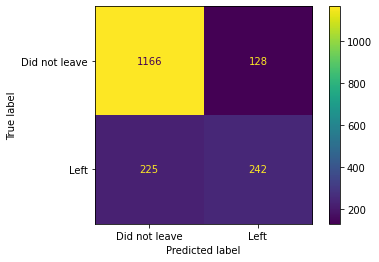

In [54]:
plot_confusion_matrix(  clf_xgb, 
                        X_test, 
                        y_test,
                        values_format='d',
                        display_labels = ["Did not leave", "Left"])

In [55]:
import pickle

file_name = './modelo_XGBoost_churn.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(clf_xgb, file)

In [56]:
with open(file_name, 'rb') as file:
    modelo_carregado = pickle.load(file)


In [57]:
modelo_carregado

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [58]:
y_predito = modelo_carregado.predict(X_test)
y_predito

d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([0, 0, 0, ..., 0, 0, 0])

__O proquê de uma previsão ruim__

Uma das cousas do porquê a classificação do XGBoost não foi tão boa é que os dados não estão balanceados. 

Para lidar com esse desbalanceamento o XGBoost possui um parâmetro, o scale_pos_weght, que ajuda a lidar com dados desbalanceados. 

Também podemos utilizar validação cruzadada para otimizar os parâmetros do modelo.

### Otimização dos parâmetros do modelo utilizando validação cruzada e GridSearch

O XGBost possui muito parâmetros que não são ajustados automaticamente pelo modelo. Temos que ajustás-lo manualmente. Desses eles:
- __max_depth__: é a profundidade máxima da árvore
- __learning_rate__ (eta): é a taxa de aprendizagem
- __gamma__: que aumenta a chance de poda dos ramos
- __reg_lambda__: é o parâmetro de regularização lambda que torna a dependência da variável dependente em relação às variáveis independentes mais suave

Como temos muitos hyperparâmetros utilizamos o __GridSearchCV__ para testar todas as possíveis combinações.

O manual do XGBoost diz que se você possui dados desbalanceados utilize a metrica AUC
- Balanceie os pesos negativos e positivos via o parâmetro __scale_pos_weight__
- E então utilize AUC para avaliar

## __1ª rodada de otimização__ com GridSearchCV

In [ ]:
param_grid_1 = {
    "max_depth": [3, 4, 5, 7, 10],
    "learning_rate": [0.3, 0.1, 0.05, 0.01],
    "gamma": [0, 0.25, 1.0],
    "reg_lambda": [0, 1.0, 10.0],
    "scale_pos_weight": [1, 2, 3, 5, 7] # XGBoost recomenda utilizar a soma(das intancias negativas)/soma(das instancias positivas)
}

In [ ]:
clf_xgb1 = xgb.XGBClassifier(objective='binary:logistic', 
                            use_label_encoder=False,
                            missing=1, 
                            seed=42,
                            subsample=0.9, # para deixar a validação cruzada mais rápida e prevenir o overfitting a cada árvore apenas 90% dos daodos
                            colsample_bytree=0.5 # utilizamos 50% das colunas 
                            )
                            
parametros_otimos1 = GridSearchCV(estimator=clf_xgb1,
                                    param_grid=param_grid_1,
                                    scoring="roc_auc", # scikit-learn model_evaluation
                                    verbose=2, # 0 para desativar, 2 para ver o que o XGBoost está fazendo
                                    n_jobs=-1, # números de núcleos de processamento utilizados. -1 utiliza todos os processadores diponíveis.
                                    cv=3 # validação cruzada
                                )


In [ ]:
parametros_otimos1.fit(X_train, 
            y_train, 
            verbose=True,
            early_stopping_rounds=20, # para parar de construir árvores quando o modelo não melhorar mais. XGBoost constrói mais 10 árvores e se não houver melhora ele para.
            eval_metric="aucpr",
            eval_set=[(X_test, y_test)])

In [ ]:
parametros_otimos.best_estimator_

In [ ]:
file_name = './modelo_XGBoost_churn_param_grid1.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(parametros_otimos, file)

In [ ]:
## __2ª rodada de otimização__ com GridSearchCV

In [ ]:
param_grid_2 = {
    "max_depth": [4],
    "learning_rate": [0.07, 0.05, 0.03],
    "gamma": [1.0, 1.5, 2.0],
    "reg_lambda": [1.0, 5.0, 10.0],
    "scale_pos_weight": [-3, -2, 1] # XGBoost recomenda utilizar a soma(das intancias negativas)/soma(das instancias positivas)
}

# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.5,
#               enable_categorical=False, gamma=1.0, gpu_id=-1,
#               importance_type=None, interaction_constraints='',
#               learning_rate=0.05, max_delta_step=0, max_depth=4,
#               min_child_weight=1, missing=1, monotone_constraints='()',
#               n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
#               random_state=42, reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1,
#               seed=42, subsample=0.9, tree_method='exact',
#               use_label_encoder=False, validate_parameters=1, verbosity=None)

clf_xgb2 = xgb.XGBClassifier(objective='binary:logistic', 
                            use_label_encoder=False,
                            missing=1, 
                            seed=42,
                            subsample=0.9, # para deixar a validação cruzada mais rápida e prevenir o overfitting a cada árvore apenas 90% dos daodos
                            colsample_bytree=0.5 # utilizamos 50% das colunas 
                            )
parametros_otimos2 = GridSearchCV(estimator=clf_xgb2,
                                    param_grid=param_grid_2,
                                    scoring="roc_auc", # scikit-learn model_evaluation
                                    verbose=2, # 0 para desativar, 2 para ver o que o XGBoost está fazendo
                                    n_jobs=-1, # números de núcleos de processamento utilizados. -1 utiliza todos os processadores diponíveis.
                                    cv=3 # validação cruzada
                                )


In [ ]:
parametros_otimos2.fit(X_train, 
            y_train, 
            verbose=True,
            early_stopping_rounds=20, # para parar de construir árvores quando o modelo não melhorar mais. XGBoost constrói mais 10 árvores e se não houver melhora ele para.
            eval_metric="aucpr",
            eval_set=[(X_test, y_test)])

In [ ]:
parametros_otimos2.best_estimator_

In [ ]:
file_name = './modelo_XGBoost_churn_param_grid2.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(parametros_otimos2, file)

In [ ]:
param_grid_3 = {
    "max_depth": [4],
    "learning_rate": [0.06, 0.05, 0.04],
    "gamma": [2.0, 4.0, 8.0],
    "reg_lambda": [10.0, 20.0, 40.0],
    "scale_pos_weight": [0.5, 1, 1.5] # XGBoost recomenda utilizar a soma(das intancias negativas)/soma(das instancias positivas)
}

clf_xgb_3 = xgb.XGBClassifier(objective='binary:logistic', 
                            use_label_encoder=False,
                            missing=1, 
                            seed=42,
                            subsample=0.9, # para deixar a validação cruzada mais rápida e prevenir o overfitting a cada árvore apenas 90% dos daodos
                            colsample_bytree=0.5 # utilizamos 50% das colunas 
                            )
parametros_otimos_3 = GridSearchCV(estimator=clf_xgb_3,
                                    param_grid=param_grid_3,
                                    scoring="roc_auc", # scikit-learn model_evaluation
                                    verbose=2, # 0 para desativar, 2 para ver o que o XGBoost está fazendo
                                    n_jobs=-1, # números de núcleos de processamento utilizados. -1 utiliza todos os processadores diponíveis.
                                    cv=5# validação cruzada
                                )

In [ ]:
parametros_otimos_3.fit(X_train, 
            y_train, 
            verbose=True,
            early_stopping_rounds=20, # para parar de construir árvores quando o modelo não melhorar mais. XGBoost constrói mais 10 árvores e se não houver melhora ele para.
            eval_metric="aucpr",
            eval_set=[(X_test, y_test)])

In [ ]:
parametros_otimos_3.best_estimator_

In [ ]:
file_name = './modelo_XGBoost_churn_param_grid3.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(parametros_otimos_3, file)

In [ ]:
param_grid_4 = {
    "max_depth": [4],
    "learning_rate": [0.06, 0.05, 0.04],
    "gamma": [2.0, 4.0, 8.0],
    "reg_lambda": [10.0, 20.0, 40.0],
    "scale_pos_weight": [0.5, 1, 1.5] # XGBoost recomenda utilizar a soma(das intancias negativas)/soma(das instancias positivas)
}

clf_xgb_4 = xgb.XGBClassifier(objective='binary:logistic', 
                            use_label_encoder=False,
                            missing=1, 
                            seed=42,
                            subsample=0.9, # para deixar a validação cruzada mais rápida e prevenir o overfitting a cada árvore apenas 90% dos daodos
                            colsample_bytree=0.5 # utilizamos 50% das colunas 
                            )
parametros_otimos_4 = GridSearchCV(estimator=clf_xgb_4,
                                    param_grid=param_grid_4,
                                    scoring="roc_auc", # scikit-learn model_evaluation
                                    verbose=2, # 0 para desativar, 2 para ver o que o XGBoost está fazendo
                                    n_jobs=-1, # números de núcleos de processamento utilizados. -1 utiliza todos os processadores diponíveis.
                                    cv=5# validação cruzada
                                )

In [ ]:
parametros_otimos_4.fit(X_train, 
            y_train, 
            verbose=True,
            early_stopping_rounds=20, # para parar de construir árvores quando o modelo não melhorar mais. XGBoost constrói mais 10 árvores e se não houver melhora ele para.
            eval_metric="aucpr",
            eval_set=[(X_test, y_test)])

In [ ]:
parametros_otimos_4.best_estimator_

In [ ]:
file_name = './modelo_XGBoost_churn_param_grid4.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(parametros_otimos_4, file)

In [59]:
clf_xgb_5 = xgb.XGBClassifier(objective='binary:logistic', 
                            use_label_encoder=False,
                            gamma = 0.25,
                            learn_rate = 0.1,
                            max_depth = 4,
                            reg_lambda = 10,
                            scale_pos_weight = 3,
                            n_estimator=1,
                            missing=1, 
                            seed=42,
                            subsample=0.9, # para deixar a validação cruzada mais rápida e prevenir o overfitting a cada árvore apenas 90% dos daodos
                            colsample_bytree=0.5 # utilizamos 50% das colunas 
                            )
clf_xgb_5.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=20, # para parar de construir árvores quando o modelo não melhorar mais. XGBoost constrói mais 10 árvores e se não houver melhora ele para.
            eval_metric="aucpr",
            eval_set=[(X_test, y_test)])
file_name = './modelo_XGBoost_churn_param_grid5.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(clf_xgb_5, file)

[10:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.50976
[1]	validation_0-aucpr:0.57467
[2]	validation_0-aucpr:0.59589
[3]	validation_0-aucpr:0.60167
[4]	validation_0-aucpr:0.60048
[5]	validation_0-aucpr:0.62906
[6]	validation_0-aucpr:0.63140
[7]	validation_0-aucpr:0.63987
[8]	validation_0-aucpr:0.64047
[9]	validation_0-aucpr:0.64404
[10]	validation_0-aucpr:0.64415
[11]	validation_0-aucpr:0.64373
[12]	validation_0-aucpr:0.64531
[13]	validation_0-aucpr:0.64318
[14]	validation_0-aucpr:0.64686
[15]	validation_0-aucpr:0.64637
[16]	validation_0-aucpr:0.64838
[17]	validation_0-aucpr:0.64570


d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


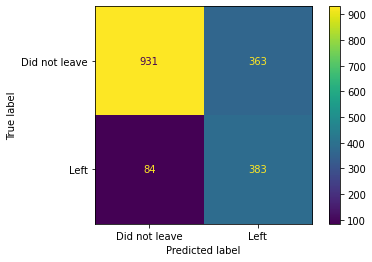

In [60]:
plot_confusion_matrix(  clf_xgb_5, 
                        X_test, 
                        y_test,
                        values_format='d',
                        display_labels = ["Did not leave", "Left"])

In [61]:
clf_xgb_5.predict(X_test)

d:\Estudos-M\Machine Learning Avançada\XGBosst_churn\env\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


array([0, 0, 0, ..., 0, 1, 1])

In [67]:
bst = clf_xgb_5.get_booster()
dict_bst = {}
for tipo_relevante in ("weight", "gain", "cover", "total_gain", "total_cover"):
    # print("%s: " % tipo_relevante, bst.get_score(importance_type=tipo_relevante))
    dict_bst.update({tipo_relevante: bst.get_score(importance_type=tipo_relevante)})
df_bst = pd.DataFrame(dict_bst)
df_bst

,weight,gain,cover,total_gain,total_cover
SeniorCitizen,14.0,3.679793,257.712860,51.517101,3607.980225
tenure,56.0,15.994608,553.954407,895.698059,31021.447266
MonthlyCharges,117.0,8.415302,377.119324,984.590332,44122.960938
TotalCharges,97.0,5.755491,345.136108,558.282593,33478.203125
gender_Female,9.0,4.110178,147.970612,36.991604,1331.735474
gender_Male,4.0,5.687869,84.992554,22.751476,339.970215
Partner_No,3.0,3.611327,775.030334,10.833981,2325.091064
Partner_Yes,2.0,6.670083,123.911400,13.340166,247.822800
Dependents_No,9.0,5.283671,318.527344,47.553040,2866.746094
Dependents_Yes,1.0,5.587090,97.500000,5.587090,97.500000


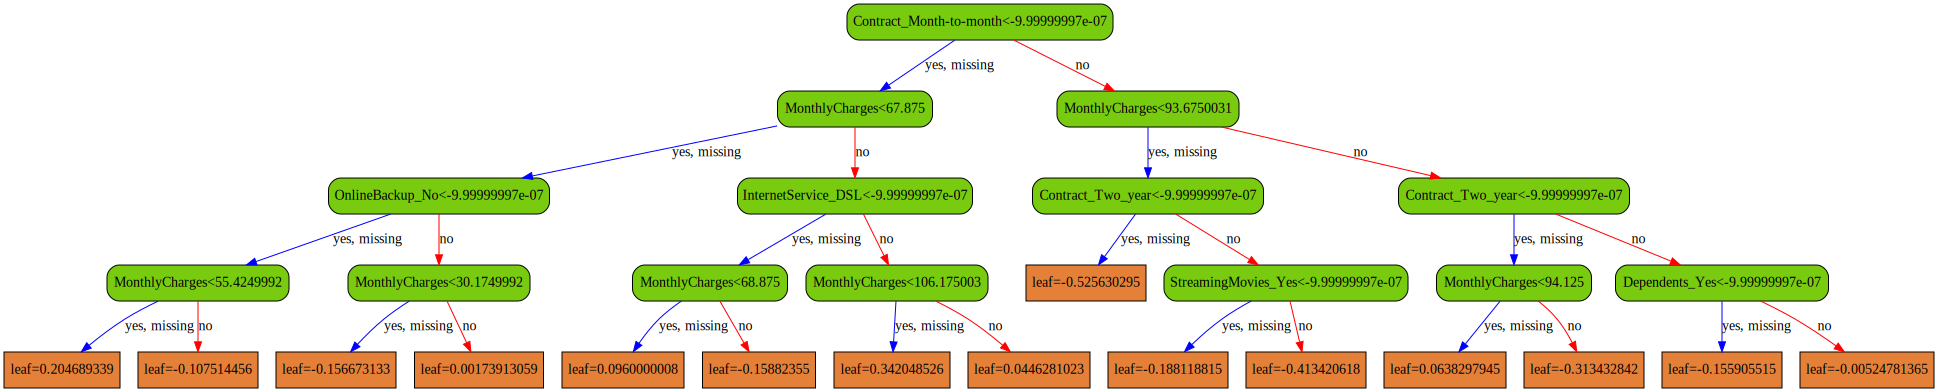

In [64]:
node_params = {"shape": "box", # Deixa o desenho dos nós mais bonitos
                "style": "filled, rounded",
                "fillcolor": "#78cbe"
                }
leaf_params = {"shape": "box",
                "style": "filled",
                "fillcolor": "#e48038"
                }
xgb.to_graphviz(clf_xgb_5, num_trees=0, size ="10, 10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)